#### Isobaric_LH2

* This notebook sets up the isobaric evaporation of liquid hydrogen in a retrofitted LNG storage tank
* Coolprop will be called to retrieve the cryogen thermophysical properties. Hence, the cryogen will be specificied in the notebook

## Desired input and output
* Tank characteristics: .CSV file with tank geometrical properties
* Cryogen: .CSV file with the cryogen ID consistent with coolprop
* Popular cryogens: hydrogen, methane, nitrogen, oxygen.


In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Use example

Analyse BOG rates of liquid hydrogen in a retrofitted LNG storage tank,and compare it to methane BOG rates

In [2]:
# Retrofitted LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 76.4 # Internal diameter / m
d_o = 80   # External diameter / m
T_air = 293.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.0371 # W/m2/K
U_V = 0.0371 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 60000 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 165000 #m^3

# Initial liquid filling / Dimensionless
LF = 0.97 

# Specify tank operating pressure
P = 100000 # Pa

# Initialize tank
large_tank = Tank(d_i, d_o, V_tank, LF)
large_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b)

In [3]:
methane = Cryogen(name = "methane")
methane.set_coolprops("methane", P)
large_tank.cryogen = methane
print("The evaporation rate of " + methane.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))

# Initialise hydrogen using CoolProp dependency
hydrogen = Cryogen(name="hydrogen")
# Initialise thermodynamic properties at the tank operating pressure
hydrogen.set_coolprops(hydrogen.name, P)
large_tank.cryogen = hydrogen

# Evaporation rate
print("The evaporation rate of " + hydrogen.name + " in the tank is %.1f kg/h" % (large_tank.b_l_dot * 3600))
print("Equivalent to %.1f g/s" % (large_tank.b_l_dot * 1000))

The evaporation rate of methane is 416.5 kg/h
The evaporation rate of hydrogen in the tank is 712.2 kg/h
Equivalent to 197.8 g/s


Liquid nitrogen properties for Linde tank calculations

#### Simulate liquid hydrogen evaporation 

In [4]:
# large_tank.evaporate(3600*24*7*52)
large_tank.z_grid = np.linspace(0, 1, 40)
large_tank.U_roof = 0

# Time step to record data, relevant for
# plotting integrated quantities such as
# the vapour to liquid heat transfer rate, Q_VL
large_tank.time_interval = 60

# Time step to plot each vapour temperature profile
large_tank.plot_interval = 3600*6
large_tank.evaporate(3600*24)

Plot vapour temperature profile

In [5]:
# Number of temperature profiles to visualise
n_plots = int(large_tank.sol.t[-1] / large_tank.plot_interval)

# Step to move in the index
plot_step = int(large_tank.plot_interval / large_tank.time_interval)

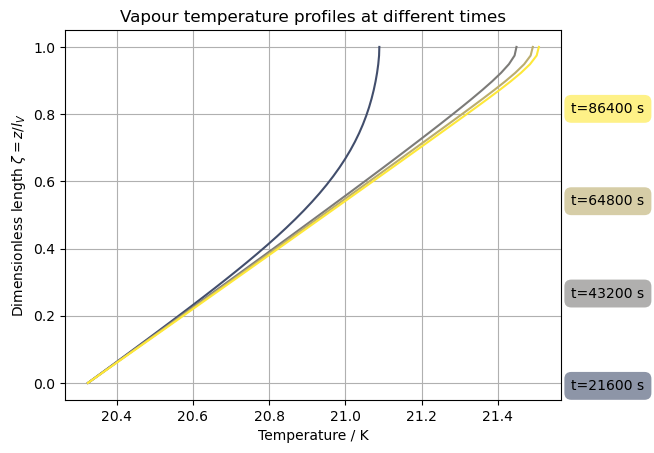

In [6]:
# Create a colormap
cmap = plt.get_cmap('cividis')

# Normalize the colormap based on the time range
norm = plt.Normalize(vmin=large_tank.sol.t[1], vmax=large_tank.sol.t[-1])

# Create a figure and axis
fig, ax = plt.subplots()

# Loop over each time step to  p
for i in range(1, n_plots+1):

    # Get the temperature at this time step
    T_v = large_tank.sol.y[1:, i*plot_step]
    
    # Plot the temperature profile at this time step, with color indicating the time
    ax.plot(T_v, large_tank.z_grid, color=cmap(norm(large_tank.sol.t[i * plot_step])))

    # Add a text box with the time value at the right of the plot
    ax.text(1.02, ((i-1 + 0.15)*plot_step) / len(large_tank.sol.t), f't={large_tank.sol.t[i*plot_step]:.0f} s', transform=ax.transAxes, 
            verticalalignment='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor=cmap(norm(large_tank.sol.t[i*plot_step])), alpha=0.6))

# Add a grid
ax.grid(True)

# Add labels
ax.set_ylabel(r'Dimensionless length $\zeta = z/l_V$')
ax.set_xlabel('Temperature / K')

# Add a title
ax.set_title('Vapour temperature profiles at different times')

# Show the plot
plt.show()

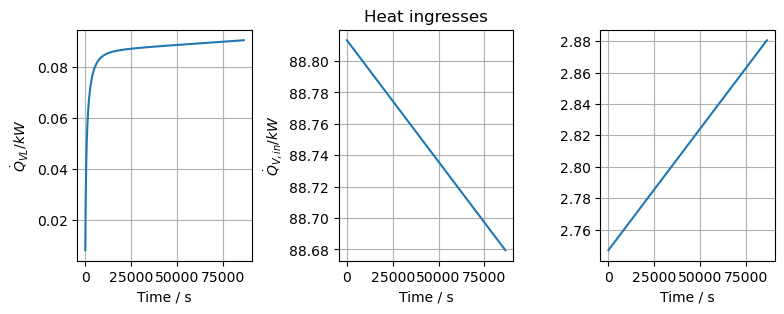

In [7]:
# Reconstruct Q_VL
Q_VL = []
for i in range(1, len(large_tank.sol.t)):
    # Get the temperature at this time step
    T_v = large_tank.sol.y[1:, i]
    Q_VL.append(large_tank.Q_VL(T_v))

Q_VL = np.array(Q_VL)

# Reconstruct Q_L_in

l_L = large_tank.sol.y[0] / large_tank.A_T
delta_T = (large_tank.T_air - large_tank.cryogen.T_sat)
Q_L = large_tank.U_L * (np.pi * large_tank.d_o * l_L) * delta_T
Q_V = large_tank.U_V * (np.pi * large_tank.d_o * (large_tank.l - l_L)) * delta_T

fig, ax = plt.subplots(1, 3, figsize = [9,3])

# Create space to breathe
plt.subplots_adjust(wspace=0.5)

# Q_VL plot
ax[0].plot(large_tank.sol.t[1:], (Q_VL/1e3), label="Q_VL")
ax[0].set_ylabel("$\dot{Q}_{VL} / kW $")
ax[0].set_xlabel("Time / s")

# Q_L_in plot
ax[1].plot(large_tank.sol.t, (Q_L/1e3))
ax[1].set_ylabel("$\dot{Q}_{L,in} / kW $")
ax[1].set_xlabel("Time / s")

ax[2].plot(large_tank.sol.t, (Q_V/1e3))
ax[1].set_ylabel("$\dot{Q}_{V,in} / kW $")
ax[2].set_xlabel("Time / s")

ax[1].set_title("Heat ingresses")

[axis.grid() for axis in ax]
plt.show()

Text(0, 0.5, '$ V_L / m^3$')

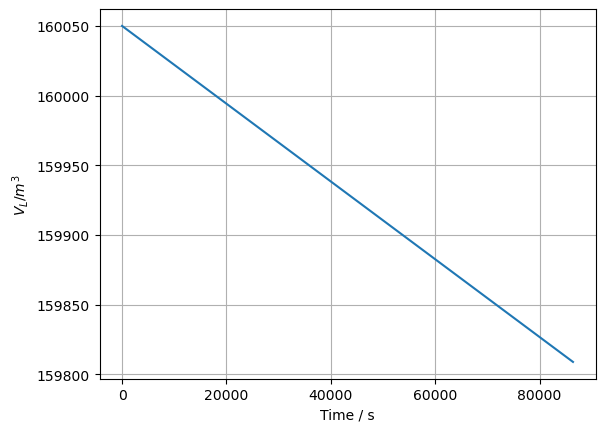

In [8]:
# Access to the liquid volume
plt.plot(large_tank.sol.t, large_tank.sol.y[0])
plt.grid()
plt.xlabel('Time / s')
plt.ylabel('$ V_L / m^3$')

Text(0, 0.5, '$ \\dot{B}_L / kg/h$')

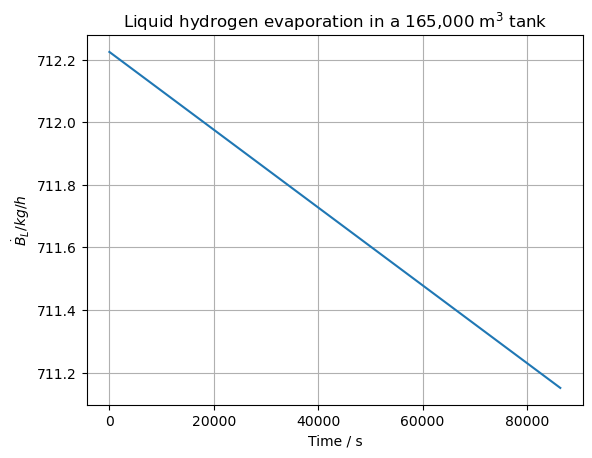

In [9]:
# Extract evaporation rate and convert to kg/h
B_L = large_tank.evap_rate() * 3600

# Visualise evaporation rate
plt.plot(large_tank.sol.t, B_L) 
plt.grid()
plt.title("Liquid hydrogen evaporation in a 165,000 m$^3$ tank")
plt.xlabel('Time / s')
plt.ylabel('$ \dot{B}_L / kg/h$')